# The convex reformulation of ReLU Networks

First, some setup to generate and plot the data we're going to train our network on.

In [42]:
import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
import torch.nn as nn
import torch.nn.functional as F

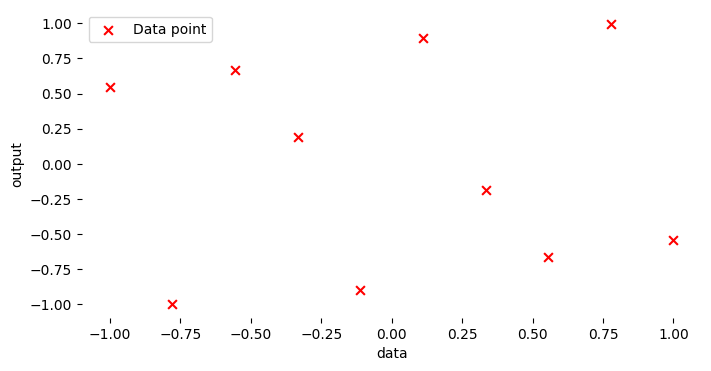

In [43]:
# Feel free to change those parameters
# Increase the number of neurons to help gradient descent!
n, m, sinfreq = 10, 500, 10
gd_step = 20000 # should take less than 5 seconds
lr, beta = 0.01, 1e-3

# we cannot  show the output for d != 2
d = 2

# generate sinus data
Xb = np.linspace(-1, 1, n)
X = np.hstack((Xb[:, None], np.ones((Xb.shape[0], 1)))) # add bias to data
Y = np.sin(Xb*sinfreq)[:, None]

# Vizualize the data
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(frameon=False)
ax.set_ylabel('output')
ax.set_xlabel('data')
ax.scatter(Xb, Y, marker="x", color="red", s=40, label="Data point")
plt.legend()
plt.show()

## Training a two-layer ReLU Network using gradient descent

In [44]:
t=torch.float32
Xt, Yt = torch.tensor(X, dtype=t), torch.tensor(Y, dtype=t)

class NN(nn.Module):
    def __init__(self, d, m):
      super(NN, self).__init__()
      self.fc1 = nn.Linear(d, m, bias=False)
      self.fc2 = nn.Linear(m, 1, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

Net = NN(d, m)
# extract the layers before optimization
ly1, ly2 = Net.fc1.weight.detach().numpy().T.copy(), Net.fc2.weight.detach().numpy().T.copy()
optimizer = torch.optim.SGD(Net.parameters(), lr=lr, momentum=0, weight_decay=0)

for i in range(gd_step+1):
    optimizer.zero_grad()
    loss = nn.MSELoss()(Net(Xt), Yt)
    loss.backward()
    optimizer.step()
    if i % 2000 == 0:
        print(i, loss.item())


0 0.5170010328292847
2000 0.36350589990615845
4000 0.23201735317707062
6000 0.13450373709201813
8000 0.07304487377405167
10000 0.03793884068727493
12000 0.018815968185663223
14000 0.008973097428679466
16000 0.00413262564688921
18000 0.001852411194704473
20000 0.0008116915123537183


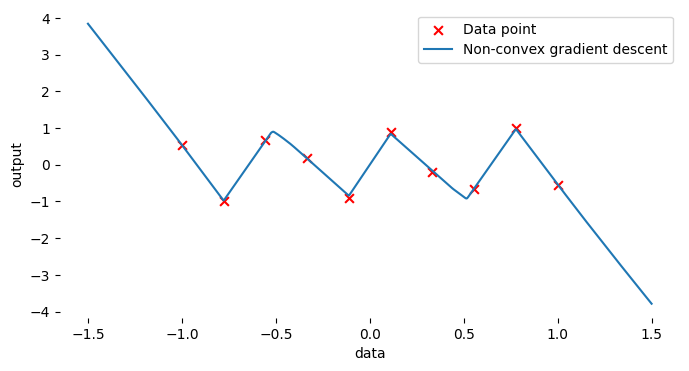

In [45]:
X_plot = np.linspace(-1.5, 1.5, 1000)
Xout = np.hstack((X_plot[:, None], np.ones((1000, 1))))
ncvx_ly1, ncvx_ly2 = Net.fc1.weight.detach().numpy().T, Net.fc2.weight.detach().numpy().T

ncvx_Yout = np.maximum(Xout@ncvx_ly1, 0) @ ncvx_ly2

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(frameon=False)
ax.set_ylabel('output')
ax.set_xlabel('data')
ax.scatter(Xb, Y, marker="x", color="red", s=40, label="Data point")
ax.plot(X_plot, ncvx_Yout, label="Non-convex gradient descent")
plt.legend()
plt.show()


Great, we've fitted the data using 500 neurons. Feel free to lower this amount or increase the learning rate (m=50, lr=0.1) to see failed attempts!

# Convex reformulation

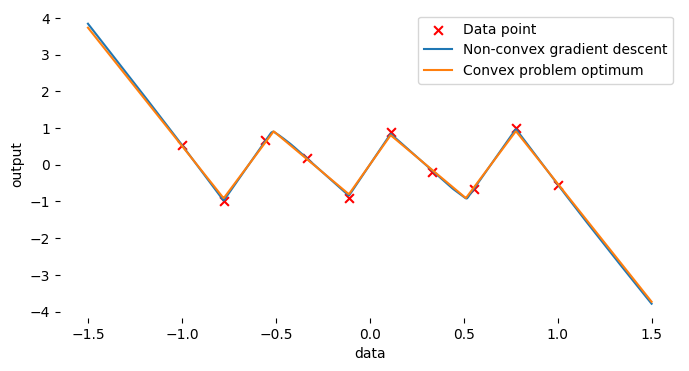

In [46]:
#ly1, ly2 are the non-convex neurons at initialization
cvx_ly1, cvx_ly2 = ly1 * np.abs(np.squeeze(ly2)), np.sign(ly2)

# activation patterns matrix at initialization
G = (X @ cvx_ly1 > 0).T

# Compute the objective in cvxpy
bet = cp.Parameter(nonneg=True)
bet.value = beta
W = cp.Variable((m, d))
Yhat = 0
for i, (si, sgn) in enumerate(zip(G, np.sign(cvx_ly2))):
    Yhat += sgn*np.diag(si) @ X @ W[i]
Yhat = cp.reshape(Yhat, (n, 1))
residuals = cp.quad_over_lin(Yhat-Y, n)
regularization = cp.sum(cp.norm(W, 2, axis=1))
obj = cp.Minimize(residuals + bet*regularization)

# Add the activation patterns constraints
constraints = []
for i, si in enumerate(G):
    constraints.append((2*np.diag(si) - np.eye(n)) @ X @ W[i] >= 0)
problem = cp.Problem(obj, constraints)

# solve the problem
problem.solve()
# Convert the convex neurons into non-convex neurons
cvx_ly1 = W.value.T
norm = np.linalg.norm(cvx_ly1, ord=2, axis=0)
cvx_ly2 = cvx_ly2.flatten()*norm
opti_ly1, opti_ly2 = cvx_ly1/norm, cvx_ly2[:, None]

cvx_Yout = np.maximum(Xout@opti_ly1, 0) @ opti_ly2

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(frameon=False)
ax.set_ylabel('output')
ax.set_xlabel('data')
ax.scatter(Xb, Y, marker="x", color="red", s=40, label="Data point")
ax.plot(X_plot, ncvx_Yout, label="Non-convex gradient descent")
ax.plot(X_plot, cvx_Yout, label="Convex problem optimum")
plt.legend()
plt.show()
